In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('daily.csv')
print(data.shape)
data.head()

(10244, 8)


,year,month,day,CO2_value,CH4_value,N2O_value,CO_value,SF6_value
0,1995,12,15,360.59,1764.21,313.380000,95.535000,3.340000
1,1995,12,16,361.76,1783.36,313.361786,96.842679,3.343571
2,1995,12,17,360.72,1762.18,313.343571,98.150357,3.347143
3,1995,12,18,360.46,1760.24,313.325357,99.458036,3.350714
4,1995,12,19,360.44,1760.78,313.307143,100.765714,3.354286


In [3]:
# Splitting the data into 80% training and 20% test sets
train_data = data.sample(frac=0.8, random_state=42)  # 80% training data
test_data = data.drop(train_data.index)  # 20% test data

# Display the first few rows of the training data to confirm it's loaded correctly
train_data.head(), train_data.shape, test_data.shape


(      year  month  day  CO2_value  CH4_value   N2O_value    CO_value  \
 590   1997      7   27    364.220    1739.33  313.801667   80.549286   
 8933  2020      5   30    416.680    1874.51  327.574500  109.153571   
 2769  2003      7   15    377.530    1775.32  318.230000   87.377143   
 7171  2015      8    3    397.490    1844.93  328.489286   75.128214   
 4030  2006     12   27    382.015    1791.86  254.027500   94.192500   
 
       SF6_value  
 590    3.805238  
 8933  10.469286  
 2769   5.332143  
 7171   8.702857  
 4030   4.832500  ,
 (8195, 8),
 (2049, 8))

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor


# 定义特征和目标列
features = ['CH4_value', 'CO_value', 'N2O_value']
target = 'CO2_value'

# 分离特征和目标
X = data[features]
y = data[target]

# 分割数据集为训练集+验证集和测试集（先划分20%作为测试集）
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

# 再次分割训练集+验证集，以得到独立的训练集和验证集（从剩余80%中划分75%作为训练集）
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=None)

def evaluate_rf_model_multiple_runs(X, y, param_grid, cv=5, runs=5):
    all_results = []
    
    for run in range(runs):
        print(f"Run {run + 1}/{runs}")
        results = []
        
        for n_estimators in param_grid['n_estimators']:
            for max_features in param_grid['max_features']:
                for max_depth in param_grid['max_depth']:
                    for min_samples_split in param_grid['min_samples_split']:
                        model = RandomForestRegressor(
                            n_estimators=n_estimators,
                            max_features=max_features,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split
                        )
                        cv_results = cross_validate(
                            model, X, y, cv=cv,
                            scoring=('neg_root_mean_squared_error', 'r2'),
                            return_train_score=False,
                            n_jobs=-1
                        )
                        results.append({
                            'n_estimators': n_estimators,
                            'max_features': max_features,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'RMSE': -np.mean(cv_results['test_neg_root_mean_squared_error']),
                            'R2': np.mean(cv_results['test_r2'])
                        })
        all_results.append(pd.DataFrame(results))
    
    combined_results = pd.concat(all_results)
    average_results = combined_results.groupby(['n_estimators', 'max_features', 'max_depth', 'min_samples_split']).agg({
        'RMSE': 'mean',
        'R2': 'mean'
    }).reset_index()
    
    return average_results

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

average_results_df = evaluate_rf_model_multiple_runs(X_train, y_train, param_grid)
print(average_results_df.sort_values(by='RMSE', ascending=True))

average_results_df.sort_values(by='RMSE', ascending=True)


Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5
    n_estimators max_features  max_depth  min_samples_split      RMSE  \
40           200         auto       20.0                  5  1.856682   
43           200         auto       30.0                  5  1.860589   
39           200         auto       20.0                  2  1.862054   
42           200         auto       30.0                  2  1.862215   
24           100         auto       30.0                  2  1.863870   
25           100         auto       30.0                  5  1.863922   
21           100         auto       20.0                  2  1.864058   
22           100         auto       20.0                  5  1.864079   
7             50         auto       30.0                  5  1.868435   
4             50         auto       20.0                  5  1.871397   
6             50         auto       30.0                  2  1.874490   
36           200         auto       10.0                  2  1.875646   
3          

,n_estimators,max_features,max_depth,min_samples_split,RMSE,R2
40,200,auto,20.0,5,1.856682,0.988965
43,200,auto,30.0,5,1.860589,0.988918
39,200,auto,20.0,2,1.862054,0.988903
42,200,auto,30.0,2,1.862215,0.988901
24,100,auto,30.0,2,1.863870,0.988881
25,100,auto,30.0,5,1.863922,0.988878
21,100,auto,20.0,2,1.864058,0.988880
22,100,auto,20.0,5,1.864079,0.988876
7,50,auto,30.0,5,1.868435,0.988829
4,50,auto,20.0,5,1.871397,0.988789


In [5]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
import numpy as np

def run_cross_validation(X, y, n_estimators, max_features, max_depth, min_samples_split, cv=5, runs=5):
    results = []

    for run in range(runs):
        print(f"Running iteration {run + 1}/{runs}")
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_features=max_features,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=None  # Remove random state for variability in runs
        )
        
        # Perform cross-validation
        cv_results = cross_validate(
            model, X, y, cv=cv,
            scoring=('neg_root_mean_squared_error', 'r2'),
            return_train_score=False,
            n_jobs=-1  # Use all available cores
        )

        # Record the results
        results.append({
            'RMSE': -np.mean(cv_results['test_neg_root_mean_squared_error']),
            'R2': np.mean(cv_results['test_r2'])
        })
    
    # Convert results to DataFrame for better display
    results_df = pd.DataFrame(results)
    return results_df

# Setting the best hyperparameters as determined
best_params = {
    'n_estimators': 200,
    'max_features': 'auto',
    'max_depth': 20,
    'min_samples_split': 5
}

# Running the cross-validation
cv_results_df = run_cross_validation(
    X_train, y_train, 
    best_params['n_estimators'],
    best_params['max_features'],
    best_params['max_depth'],
    best_params['min_samples_split']
)

# Print each iteration results
print(cv_results_df)


Running iteration 1/5
Running iteration 2/5
Running iteration 3/5
Running iteration 4/5
Running iteration 5/5
       RMSE        R2
0  1.857696  0.988954
1  1.854807  0.988989
2  1.859491  0.988934
3  1.857372  0.988962
4  1.859632  0.988932


In [6]:
cv_results_df

,RMSE,R2
0,1.857696,0.988954
1,1.854807,0.988989
2,1.859491,0.988934
3,1.857372,0.988962
4,1.859632,0.988932


In [7]:
# 计算平均 RMSE 和 R2
average_rmse = cv_results_df['RMSE'].mean()
average_r2 = cv_results_df['R2'].mean()

# 打印平均结果
print("Average RMSE:", average_rmse)
print("Average R2:", average_r2)


Average RMSE: 1.857799712411012
Average R2: 0.9889543323405123


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 使用最佳超参数重新训练模型
best_rf_model = RandomForestRegressor(
    n_estimators=200,
    max_features='auto',
    max_depth=20,
    min_samples_split=5,
    random_state=None  # Optionally, remove or set a random state for reproducibility
)

# 使用所有训练数据训练模型
best_rf_model.fit(X_train, y_train)

# 现在模型已训练并可以使用, 你可以用这个模型来做后续的测试集预测
y_pred = best_rf_model.predict(X_test)

# 计算测试集上的 RMSE 和 R2
test_rmse = mean_squared_error(y_test, y_pred, squared=False)  # squared=False 返回 RMSE
test_r2 = r2_score(y_test, y_pred)

# 打印测试结果
print("Test RMSE:", test_rmse)
print("Test R2:", test_r2)



D:\Anaconda\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Test RMSE: 1.8411636318215294
Test R2: 0.9888878325887805


In [9]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import cross_validate
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np
# import pandas as pd

# # 超参数调整
# def run_decision_tree_cv(X, y, param_grid, cv=5, runs=5):
#     all_results = []
    
#     for run in range(runs):
#         print(f"Running iteration {run + 1}/{runs}")
#         results = []
        
#         for max_depth in param_grid['max_depth']:
#             for min_samples_split in param_grid['min_samples_split']:
#                 model = DecisionTreeRegressor(
#                     max_depth=max_depth,
#                     min_samples_split=int(min_samples_split),  # 确保 min_samples_split 是整数
#                     random_state=None
#                 )
                
#                 # Perform cross-validation
#                 cv_results = cross_validate(
#                     model, X, y, cv=cv,
#                     scoring=('neg_root_mean_squared_error', 'r2'),
#                     return_train_score=False,
#                     n_jobs=-1  # Use all available cores
#                 )

#                 # Record the results
#                 results.append({
#                     'max_depth': max_depth,
#                     'min_samples_split': min_samples_split,
#                     'RMSE': -np.mean(cv_results['test_neg_root_mean_squared_error']),
#                     'R2': np.mean(cv_results['test_r2'])
#                 })
        
#         all_results.append(pd.DataFrame(results))
    
#     # Combine results from all runs
#     combined_results = pd.concat(all_results)
#     average_results = combined_results.groupby(['max_depth', 'min_samples_split']).agg({
#         'RMSE': 'mean',
#         'R2': 'mean'
#     }).reset_index()
    
#     return average_results

# # 参数
# param_grid = {
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5]  # 作为整数提供
# }

# # 运行交叉验证
# average_results_df = run_decision_tree_cv(X_train, y_train, param_grid)
# print(average_results_df.sort_values(by='RMSE'))

# # 使用最佳参数训练模型
# best_params = average_results_df.loc[average_results_df['RMSE'].idxmin()]
# best_model = DecisionTreeRegressor(
#     max_depth=best_params['max_depth'],
#     min_samples_split=int(best_params['min_samples_split'])  # 确保是整数
# )

# # 训练模型
# best_model.fit(X_train, y_train)

# # 使用测试集评估模型
# y_pred = best_model.predict(X_test)
# test_rmse = mean_squared_error(y_test, y_pred, squared=False)
# test_r2 = r2_score(y_test, y_pred)

# # 打印测试结果
# print("Test RMSE:", test_rmse)
# print("Test R2:", test_r2)


In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_decision_tree_multiple_runs(X, y, best_params, cv=5, runs=5):
    all_results = []
    
    for run in range(runs):
        print(f"Running iteration {run + 1}/{runs}")
        model = DecisionTreeRegressor(
            max_depth=best_params['max_depth'],
            min_samples_split=int(best_params['min_samples_split']),
            random_state=None  # Remove random state for variability in runs
        )
        
        # Perform cross-validation
        cv_results = cross_validate(
            model, X, y, cv=cv,
            scoring=('neg_root_mean_squared_error', 'r2'),
            return_train_score=False,
            n_jobs=-1  # Use all available cores
        )

        # Record the results
        all_results.append({
            'RMSE': -np.mean(cv_results['test_neg_root_mean_squared_error']),
            'R2': np.mean(cv_results['test_r2'])
        })
    
    # Convert results to DataFrame for better display
    results_df = pd.DataFrame(all_results)
    return results_df

# Using the best parameters determined earlier
best_params = {
    'max_depth': 20,
    'min_samples_split': 5
}

# Running the cross-validation multiple times with the best parameters
final_results_df = evaluate_decision_tree_multiple_runs(X_train, y_train, best_params)
print(final_results_df)

# Calculating the average RMSE and R2
average_rmse = final_results_df['RMSE'].mean()
average_r2 = final_results_df['R2'].mean()

# Printing the average results
print("\nAverage RMSE:", average_rmse)
print("Average R2:", average_r2)


Running iteration 1/5
Running iteration 2/5
Running iteration 3/5
Running iteration 4/5
Running iteration 5/5
       RMSE        R2
0  2.387085  0.981799
1  2.365518  0.982080
2  2.375886  0.981974
3  2.366893  0.982074
4  2.378103  0.981912

Average RMSE: 2.3746970468057866
Average R2: 0.9819678083932715


In [11]:
final_results_df

,RMSE,R2
0,2.387085,0.981799
1,2.365518,0.982080
2,2.375886,0.981974
3,2.366893,0.982074
4,2.378103,0.981912


In [12]:
average_results_df.sort_values(by='RMSE')

,n_estimators,max_features,max_depth,min_samples_split,RMSE,R2
40,200,auto,20.0,5,1.856682,0.988965
43,200,auto,30.0,5,1.860589,0.988918
39,200,auto,20.0,2,1.862054,0.988903
42,200,auto,30.0,2,1.862215,0.988901
24,100,auto,30.0,2,1.863870,0.988881
25,100,auto,30.0,5,1.863922,0.988878
21,100,auto,20.0,2,1.864058,0.988880
22,100,auto,20.0,5,1.864079,0.988876
7,50,auto,30.0,5,1.868435,0.988829
4,50,auto,20.0,5,1.871397,0.988789


In [13]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import pandas as pd
import numpy as np

def optimize_xgboost(X_train, y_train):
    # Define the model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }

    # Setup the grid search with cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Output all results
    results_df = pd.DataFrame(grid_search.cv_results_)
    print(results_df[['param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_subsample', 'param_colsample_bytree', 'mean_test_score', 'std_test_score', 'rank_test_score']])
    
    return grid_search.best_params_

# Get the best hyperparameters
best_params = optimize_xgboost(X_train, y_train)
print("Best hyperparameters:", best_params)

# Define function for multiple CV runs with best parameters
def evaluate_xgboost_multiple_runs(X, y, best_params, cv=5, runs=5):
    all_results = []
    
    for run in range(runs):
        print(f"Running iteration {run + 1}/{runs}")
        model = xgb.XGBRegressor(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            objective='reg:squarederror',
            random_state=None
        )
        
        # Perform cross-validation
        cv_results = cross_validate(
            model, X, y, cv=cv,
            scoring=('neg_root_mean_squared_error', 'r2'),
            return_train_score=False,
            n_jobs=-1  # Use all available cores
        )

        # Record the results
        all_results.append({
            'RMSE': -np.mean(cv_results['test_neg_root_mean_squared_error']),
            'R2': np.mean(cv_results['test_r2'])
        })
    
    # Convert results to DataFrame for better display
    results_df = pd.DataFrame(all_results)
    return results_df

# Running the cross-validation multiple times with the best parameters
final_results_df = evaluate_xgboost_multiple_runs(X_train, y_train, best_params)
print(final_results_df)

# Calculating the average RMSE and R2
average_rmse = final_results_df['RMSE'].mean()
average_r2 = final_results_df['R2'].mean()

# Printing the average results
print("\nAverage RMSE:", average_rmse)
print("Average R2:", average_r2)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
    param_n_estimators param_max_depth param_learning_rate param_subsample  \
0                  100               3                0.05             0.7   
1                  100               3                0.05             0.8   
2                  100               3                0.05             0.9   
3                  200               3                0.05             0.7   
4                  200               3                0.05             0.8   
..                 ...             ...                 ...             ...   
157                100               9                 0.2             0.8   
158                100               9                 0.2             0.9   
159                200               9                 0.2             0.7   
160                200               9                 0.2             0.8   
161                200               9                 0.2             0.9   



In [14]:
final_results_df

,RMSE,R2
0,2.158262,0.985124
1,2.158262,0.985124
2,2.158262,0.985124
3,2.158262,0.985124
4,2.158262,0.985124


In [15]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 定义用于优化XGBoost的函数
def optimize_xgboost(X_train, y_train):
    model = xgb.XGBRegressor(objective='reg:squarederror')
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best hyperparameters found: ", grid_search.best_params_)
    return grid_search.best_estimator_

# 假设 X_train, y_train, X_test, y_test 已经定义

# 获取最佳超参数并训练模型
best_model = optimize_xgboost(X_train, y_train)

# 使用训练好的模型在测试集上进行预测
y_pred = best_model.predict(X_test)

# 计算测试集上的 RMSE 和 R2
test_rmse = mean_squared_error(y_test, y_pred, squared=False)  # squared=False 返回 RMSE
test_r2 = r2_score(y_test, y_pred)

# 打印测试结果
print("Test RMSE:", test_rmse)
print("Test R2:", test_r2)


Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best hyperparameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Test RMSE: 2.1596334483635524
Test R2: 0.9847111756722757


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score


# 假设你的数据已经按日期排序
data['PrevDayCO2'] = data['CO2_value'].shift(1)  # 创建前一天的 CO2 值特征
data.dropna(inplace=True)  # 删除因为shift引起的任何NaN值行

features = ['CH4_value', 'CO_value', 'N2O_value', 'PrevDayCO2']
target = 'CO2_value'

# 分割数据
X = data[features]
y = data[target]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=None)

# 模型评估函数
def model_evaluation(name, model, param_grid, X_train, y_train, X_val, y_val, results, cv=5):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # 打印最佳超参数
    print(f"{name} - Best hyperparameters: ", grid_search.best_params_)

    cv_results = cross_validate(best_model, X_val, y_val, cv=cv, scoring=('neg_root_mean_squared_error', 'r2'), n_jobs=-1)
    rmse = -np.mean(cv_results['test_neg_root_mean_squared_error'])
    r2 = np.mean(cv_results['test_r2'])
    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})
    
    # 测试集评估
    y_pred = best_model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    test_r2 = r2_score(y_test, y_pred)
    results.append({'Model': name + ' (Test Set)', 'RMSE': test_rmse, 'R2': test_r2})

# 模型和参数
models_params = {
    'Random Forest': (RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
        
    }),
    'Decision Tree': (DecisionTreeRegressor(), {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]  # 作为整数提供
    }),
    'XGBoost': (xgb.XGBRegressor(objective='reg:squarederror'), {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    })
}

results = []
for name, (model, params) in models_params.items():
    model_evaluation(name, model, params, X_train, y_train, X_val, y_val, results)

# 将结果输出为 DataFrame 并打印
results_df = pd.DataFrame(results)
print(results_df)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Random Forest - Best hyperparameters:  {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Decision Tree - Best hyperparameters:  {'max_depth': 10, 'min_samples_split': 10}
Fitting 3 folds for each of 162 candidates, totalling 486 fits
XGBoost - Best hyperparameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
                      Model      RMSE        R2
0             Random Forest  0.639197  0.998644
1  Random Forest (Test Set)  0.542126  0.999056
2             Decision Tree  0.708198  0.998381
3  Decision Tree (Test Set)  0.656621  0.998616
4                   XGBoost  0.601389  0.998829
5        XGBoost (Test Set)  0.540157  0.999063


In [17]:
results_df

,Model,RMSE,R2
0,Random Forest,0.639197,0.998644
1,Random Forest (Test Set),0.542126,0.999056
2,Decision Tree,0.708198,0.998381
3,Decision Tree (Test Set),0.656621,0.998616
4,XGBoost,0.601389,0.998829
5,XGBoost (Test Set),0.540157,0.999063


In [18]:

# 假设你的数据已经按日期排序
data['PrevDayCO2'] = data['CO2_value'].shift(1)  # 创建前一天的 CO2 值特征
for variable in ['CH4_value', 'N2O_value', 'CO_value', 'CO2_value']:
    for window in [7]:
        data[f'{variable}_mean_{window}d'] = data[variable].rolling(window=window, min_periods=1).mean()
        data[f'{variable}_std_{window}d'] = data[variable].rolling(window=window, min_periods=1).std()

data.dropna(inplace=True)  # 删除因为shift引起的任何NaN值行

features = ['CH4_value', 'CO_value', 'N2O_value', 'PrevDayCO2',
            'CH4_value_mean_7d', 'CH4_value_std_7d', 
            'N2O_value_mean_7d', 'N2O_value_std_7d', 
            'CO_value_mean_7d', 'CO_value_std_7d',
            'CO2_value_mean_7d', 'CO2_value_std_7d']
target = 'CO2_value'

# 分割数据
X = data[features]
y = data[target]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=None)

# 定义模型评估函数，之前的部分不变

results = []
for name, (model, params) in models_params.items():
    model_evaluation(name, model, params, X_train, y_train, X_val, y_val, results)

# 输出结果
results_df = pd.DataFrame(results)
print(results_df)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


D:\Anaconda\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Random Forest - Best hyperparameters:  {'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Decision Tree - Best hyperparameters:  {'max_depth': 10, 'min_samples_split': 10}
Fitting 3 folds for each of 162 candidates, totalling 486 fits
XGBoost - Best hyperparameters:  {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.7}
                      Model      RMSE        R2
0             Random Forest  0.501520  0.999186
1  Random Forest (Test Set)  0.475194  0.999269
2             Decision Tree  0.647884  0.998637
3  Decision Tree (Test Set)  0.573463  0.998935
4                   XGBoost  0.483725  0.999243
5        XGBoost (Test Set)  0.426047  0.999412


In [19]:
results_df

,Model,RMSE,R2
0,Random Forest,0.501520,0.999186
1,Random Forest (Test Set),0.475194,0.999269
2,Decision Tree,0.647884,0.998637
3,Decision Tree (Test Set),0.573463,0.998935
4,XGBoost,0.483725,0.999243
5,XGBoost (Test Set),0.426047,0.999412


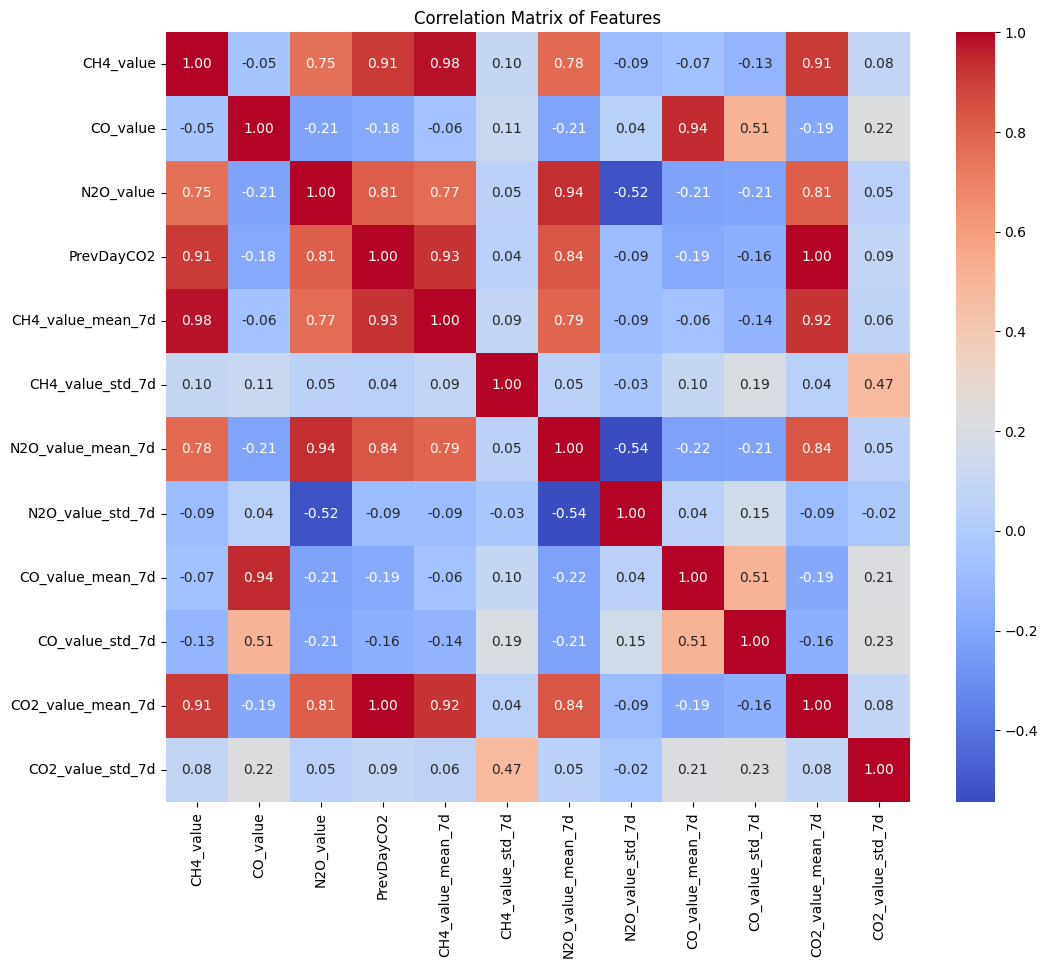

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
# 计算特征之间的相关系数
corr = data[features].corr()

# 创建一个热图来显示这些特征之间的相关性
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

In [21]:
results_df

,Model,RMSE,R2
0,Random Forest,0.501520,0.999186
1,Random Forest (Test Set),0.475194,0.999269
2,Decision Tree,0.647884,0.998637
3,Decision Tree (Test Set),0.573463,0.998935
4,XGBoost,0.483725,0.999243
5,XGBoost (Test Set),0.426047,0.999412


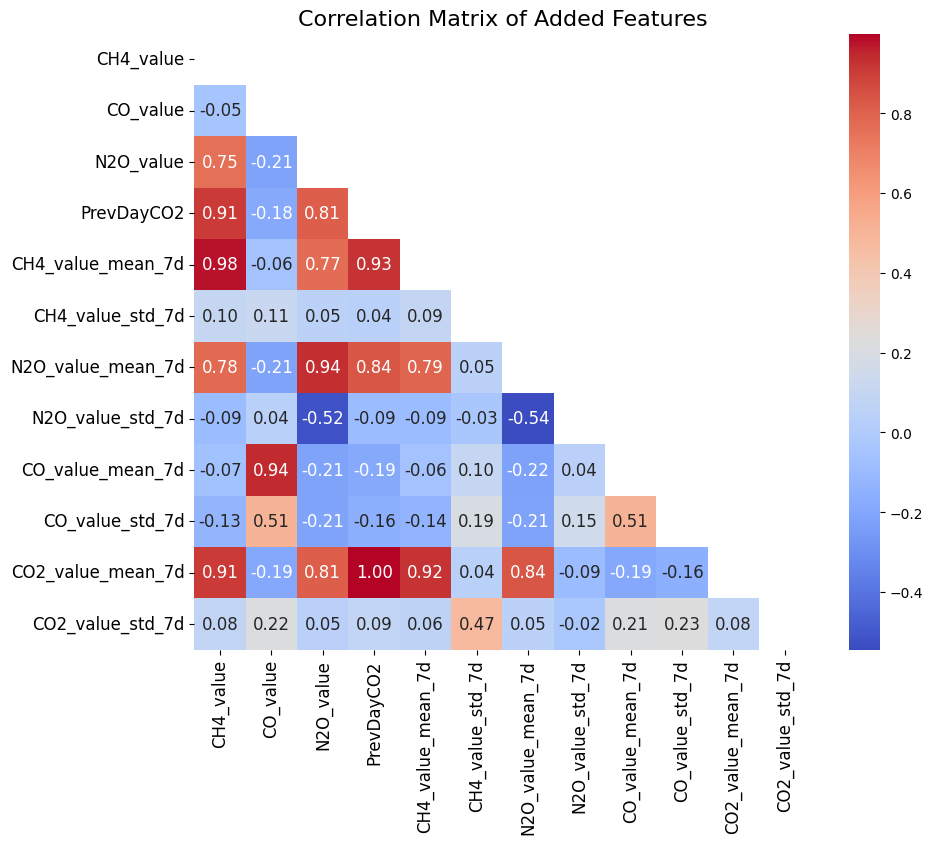

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# 计算特征之间的相关系数
corr = data[features].corr()

# 创建上三角的掩码
mask = np.triu(np.ones_like(corr, dtype=bool))

# 创建一个热图来显示这些特征之间的相关性
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, annot_kws={"size": 12})

# 增加标签的字体大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 设置标题的字体大小
plt.title('Correlation Matrix of Added Features', fontsize=16)

plt.show()
